In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as plt 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('train.csv',index_col=0 , parse_dates=True)

In [3]:
df.head()

,temp
DATE,
1876-01-01,22
1876-01-02,25
1876-01-03,3
1876-01-04,-58
1876-01-05,-98


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52886 entries, 1876-01-01 to 2021-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   temp    52886 non-null  int64
dtypes: int64(1)
memory usage: 826.3 KB


In [5]:
df['timestep'] = range(len(df))


In [6]:
seasonal_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
df = df.join(seasonal_dummies)

In [7]:
X = df.drop('temp', axis=1)
y = df['temp']

In [8]:
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [9]:
df['trend_seasonal'] = m.predict(X)

In [10]:
df['trend_seasonal'].unique()

array([-8.70875706, -8.7084294 , -8.70810175, ..., 97.16861905,
       97.16894671, 97.16927436])

In [11]:
df.head()

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
1876-01-01,22,0,0,0,0,0,0,0,0,0,0,0,0,-8.708757
1876-01-02,25,1,0,0,0,0,0,0,0,0,0,0,0,-8.708429
1876-01-03,3,2,0,0,0,0,0,0,0,0,0,0,0,-8.708102
1876-01-04,-58,3,0,0,0,0,0,0,0,0,0,0,0,-8.707774
1876-01-05,-98,4,0,0,0,0,0,0,0,0,0,0,0,-8.707446


In [12]:
df['remainder'] = df['temp'] - df['trend_seasonal']

In [13]:
df['lag1'] = df['remainder'].shift(4)

In [14]:
df.head()

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,
1876-01-01,22,0,0,0,0,0,0,0,0,0,0,0,0,-8.708757,30.708757,NaN
1876-01-02,25,1,0,0,0,0,0,0,0,0,0,0,0,-8.708429,33.708429,NaN
1876-01-03,3,2,0,0,0,0,0,0,0,0,0,0,0,-8.708102,11.708102,NaN
1876-01-04,-58,3,0,0,0,0,0,0,0,0,0,0,0,-8.707774,-49.292226,NaN
1876-01-05,-98,4,0,0,0,0,0,0,0,0,0,0,0,-8.707446,-89.292554,30.708757


In [15]:
df.dropna(inplace=True)
X_full = df.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
y_full = df['temp']



In [16]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [17]:
df['full_model'] = m_full.predict(X_full)

<AxesSubplot:xlabel='    DATE'>

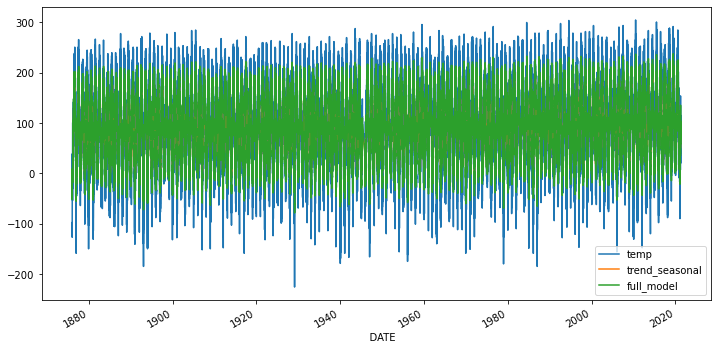

In [18]:
df[['temp', 'trend_seasonal', 'full_model']].plot()

<AxesSubplot:xlabel='    DATE'>

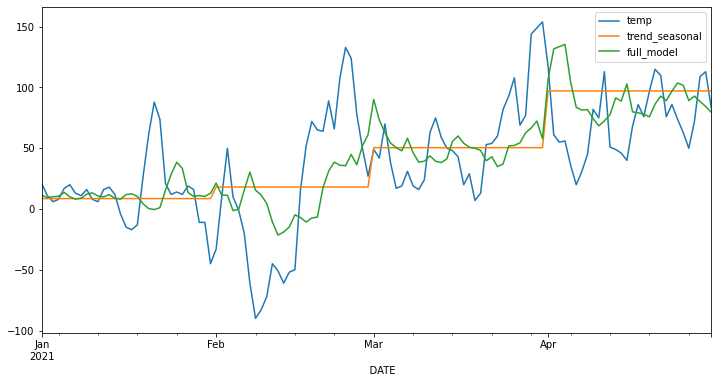

In [19]:
data = df[df.index.year>=2021]
data[['temp', 'trend_seasonal', 'full_model']].plot()

In [20]:
df['remainder_full_model'] = df['temp'] - df['full_model']

<AxesSubplot:xlabel='    DATE'>

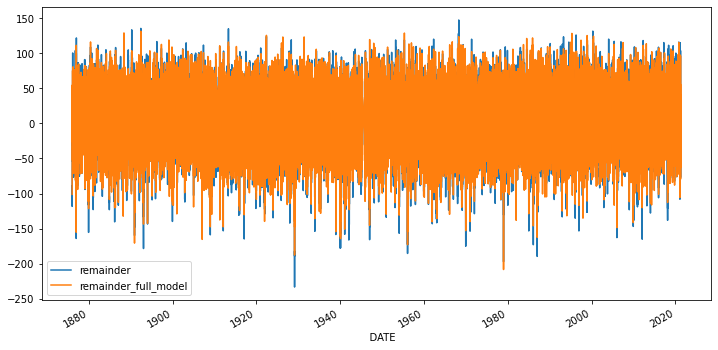

In [21]:
df[['remainder', 'remainder_full_model']].plot()

<AxesSubplot:xlabel='    DATE'>

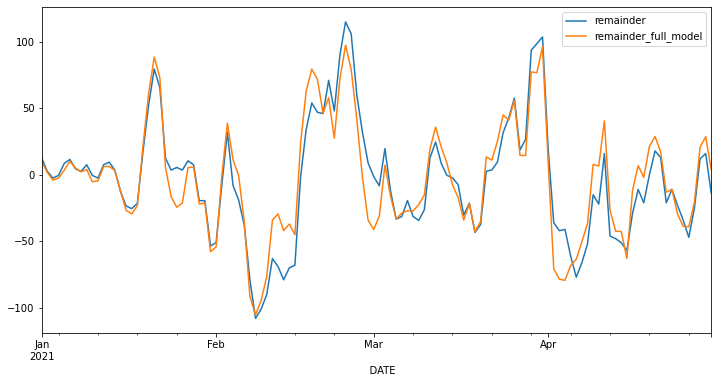

In [22]:
data_1 = df[df.index.year>=2021]
data_1[['remainder', 'remainder_full_model']].plot()

In [23]:
df.drop('remainder_full_model', axis=1, inplace=True)

In [24]:
ts_split = TimeSeriesSplit(n_splits=5)

In [25]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 8816
The validation data for the 1th iteration are the observations 8817 to 17629

The training data for the 2th iteration are the observations 0 to 17629
The validation data for the 2th iteration are the observations 17630 to 26442

The training data for the 3th iteration are the observations 0 to 26442
The validation data for the 3th iteration are the observations 26443 to 35255

The training data for the 4th iteration are the observations 0 to 35255
The validation data for the 4th iteration are the observations 35256 to 44068

The training data for the 5th iteration are the observations 0 to 44068
The validation data for the 5th iteration are the observations 44069 to 52881



In [26]:
time_series_split = ts_split.split(X_full, y_full)

In [27]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)

In [28]:
result

array([0.77095423, 0.78341022, 0.79047383, 0.77498139, 0.77892848])

In [29]:
round(result.mean(), 3)

0.78

In [30]:
temp_train = df.copy()

In [31]:
temp_test = pd.read_csv('test.csv', index_col=0, parse_dates=True)


In [32]:
temp_test

,temp
DATE,
2021-05-01,92
2021-05-02,81
2021-05-03,74
2021-05-04,101
2021-05-05,88
...,...
2022-04-26,115
2022-04-27,121
2022-04-28,115


In [33]:
last_train_timestep = temp_train['timestep'][-1]

In [34]:
last_train_timestep

52885

In [35]:
temp_test['timestep'] = range(last_train_timestep+1, last_train_timestep+1+len(temp_test))

In [36]:
temp_test

,temp,timestep
DATE,,
2021-05-01,92,52886
2021-05-02,81,52887
2021-05-03,74,52888
2021-05-04,101,52889
2021-05-05,88,52890
...,...,...
2022-04-26,115,53246
2022-04-27,121,53247
2022-04-28,115,53248


In [37]:
seasonal_dummies_1 = pd.get_dummies(temp_test.index.month, drop_first=True, prefix='month').set_index(temp_test.index)

In [38]:
temp_test = temp_test.join(seasonal_dummies_1)

In [39]:
temp_test

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2021-05-01,92,52886,0,0,0,1,0,0,0,0,0,0,0
2021-05-02,81,52887,0,0,0,1,0,0,0,0,0,0,0
2021-05-03,74,52888,0,0,0,1,0,0,0,0,0,0,0
2021-05-04,101,52889,0,0,0,1,0,0,0,0,0,0,0
2021-05-05,88,52890,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,115,53246,0,0,1,0,0,0,0,0,0,0,0
2022-04-27,121,53247,0,0,1,0,0,0,0,0,0,0,0
2022-04-28,115,53248,0,0,1,0,0,0,0,0,0,0,0


In [40]:
temp_test.isnull().sum()

temp        0
timestep    0
month_2     0
month_3     0
month_4     0
month_5     0
month_6     0
month_7     0
month_8     0
month_9     0
month_10    0
month_11    0
month_12    0
dtype: int64

In [41]:
X_test = temp_test.drop('temp', axis=1)

In [42]:
temp_test['trend_seasonal'] = m.predict(X_test)

<AxesSubplot:xlabel='    DATE'>

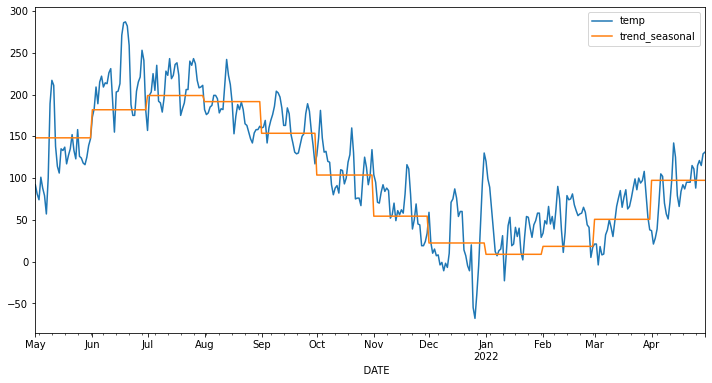

In [43]:
temp_test[['temp', 'trend_seasonal']].plot()

In [44]:
temp_test['remainder'] = temp_test['temp'] - temp_test['trend_seasonal']

In [45]:
temp_test['lag1'] = temp_test['remainder'].shift(4)
temp_test.head()

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,
2021-05-01,92,52886,0,0,0,1,0,0,0,0,0,0,0,148.153040,-56.153040,NaN
2021-05-02,81,52887,0,0,0,1,0,0,0,0,0,0,0,148.153367,-67.153367,NaN
2021-05-03,74,52888,0,0,0,1,0,0,0,0,0,0,0,148.153695,-74.153695,NaN
2021-05-04,101,52889,0,0,0,1,0,0,0,0,0,0,0,148.154022,-47.154022,NaN
2021-05-05,88,52890,0,0,0,1,0,0,0,0,0,0,0,148.154350,-60.154350,-56.15304


In [46]:
temp_test.loc['2021-05-01', 'lag1'] = temp_train.loc['2021-04-30', 'remainder']
temp_test.loc['2021-05-02', 'lag1'] = temp_train.loc['2021-04-30', 'remainder']
temp_test.loc['2021-05-03', 'lag1'] = temp_train.loc['2021-04-30', 'remainder']
temp_test.loc['2021-05-04', 'lag1'] = temp_train.loc['2021-04-30', 'remainder']


In [47]:
X_full_1 = temp_test.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)


In [48]:
temp_test['full_model'] = m_full.predict(X_full_1)

In [49]:
temp_test

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
2021-05-01,92,52886,0,0,0,1,0,0,0,0,0,0,0,148.153040,-56.153040,-14.169274,142.840161
2021-05-02,81,52887,0,0,0,1,0,0,0,0,0,0,0,148.153367,-67.153367,-14.169274,142.840488
2021-05-03,74,52888,0,0,0,1,0,0,0,0,0,0,0,148.153695,-74.153695,-14.169274,142.840816
2021-05-04,101,52889,0,0,0,1,0,0,0,0,0,0,0,148.154022,-47.154022,-14.169274,142.841144
2021-05-05,88,52890,0,0,0,1,0,0,0,0,0,0,0,148.154350,-60.154350,-56.153040,127.268575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,115,53246,0,0,1,0,0,0,0,0,0,0,0,97.287558,17.712442,-2.286247,96.344179
2022-04-27,121,53247,0,0,1,0,0,0,0,0,0,0,0,97.287885,23.712115,17.713425,103.762917
2022-04-28,115,53248,0,0,1,0,0,0,0,0,0,0,0,97.288213,17.711787,13.713098,102.279417


In [50]:
temp_full = temp_train[['temp', 'trend_seasonal', 'full_model']]\
    .append(temp_test[['temp', 'trend_seasonal', 'full_model']])

In [51]:
temp_full

,temp,trend_seasonal,full_model
DATE,,,
1876-01-05,-98,-8.707446,3.167118
1876-01-06,-77,-8.707119,4.280104
1876-01-07,-66,-8.706791,-3.880075
1876-01-08,-89,-8.706463,-26.506392
1876-01-09,-127,-8.706136,-41.343251
...,...,...,...
2022-04-26,115,97.287558,96.344179
2022-04-27,121,97.287885,103.762917
2022-04-28,115,97.288213,102.279417


<AxesSubplot:xlabel='    DATE'>

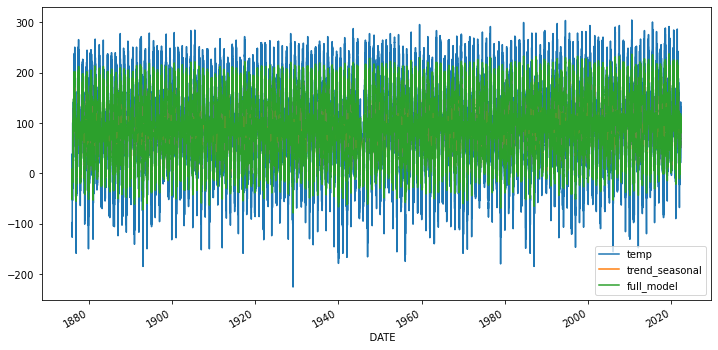

In [52]:
temp_full.plot()

In [53]:
round(m_full.score(X_full_1, temp_test['temp']), 3)

0.765

****predict the future 

In [54]:
temp_combined = temp_train.append(temp_test)

In [55]:
temp_combined

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-05,-98,4,0,0,0,0,0,0,0,0,0,0,0,-8.707446,-89.292554,30.708757,3.167118
1876-01-06,-77,5,0,0,0,0,0,0,0,0,0,0,0,-8.707119,-68.292881,33.708429,4.280104
1876-01-07,-66,6,0,0,0,0,0,0,0,0,0,0,0,-8.706791,-57.293209,11.708102,-3.880075
1876-01-08,-89,7,0,0,0,0,0,0,0,0,0,0,0,-8.706463,-80.293537,-49.292226,-26.506392
1876-01-09,-127,8,0,0,0,0,0,0,0,0,0,0,0,-8.706136,-118.293864,-89.292554,-41.343251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,115,53246,0,0,1,0,0,0,0,0,0,0,0,97.287558,17.712442,-2.286247,96.344179
2022-04-27,121,53247,0,0,1,0,0,0,0,0,0,0,0,97.287885,23.712115,17.713425,103.762917
2022-04-28,115,53248,0,0,1,0,0,0,0,0,0,0,0,97.288213,17.711787,13.713098,102.279417


In [56]:
X_combined = temp_combined.drop(columns=['temp', 'trend_seasonal', 'remainder', 'full_model'])
y_combined = temp_combined['temp']

In [57]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [58]:
X_combined.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1'],
      dtype='object')

In [67]:
timestep = temp_combined['timestep'].max() + 1
months = [0] * 11
months[3]= 1
lag = temp_combined.loc['2022-04-30', 'remainder']

In [68]:
X_future1 = []
X_future1.append(timestep)
X_future1.extend(months)
X_future1.append(lag)

In [69]:
X_future1

[53251, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 33.71113182587432]

In [71]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

ValueError: Must pass 2-d input. shape=(1, 1, 13)

In [63]:
X_future1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,53251,0,0,0,0,0,0,0,0,0,0,0,33.711132


In [64]:
y_future1 = m_combined.predict(X_future1)

In [65]:
y_future1

array([21.93442537])

In [66]:
temp_train

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-05,-98,4,0,0,0,0,0,0,0,0,0,0,0,-8.707446,-89.292554,30.708757,3.167118
1876-01-06,-77,5,0,0,0,0,0,0,0,0,0,0,0,-8.707119,-68.292881,33.708429,4.280104
1876-01-07,-66,6,0,0,0,0,0,0,0,0,0,0,0,-8.706791,-57.293209,11.708102,-3.880075
1876-01-08,-89,7,0,0,0,0,0,0,0,0,0,0,0,-8.706463,-80.293537,-49.292226,-26.506392
1876-01-09,-127,8,0,0,0,0,0,0,0,0,0,0,0,-8.706136,-118.293864,-89.292554,-41.343251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,50,52881,0,0,1,0,0,0,0,0,0,0,0,97.167964,-47.167964,-21.166653,89.221335
2021-04-27,72,52882,0,0,1,0,0,0,0,0,0,0,0,97.168291,-25.168291,-11.166981,92.930808
2021-04-28,109,52883,0,0,1,0,0,0,0,0,0,0,0,97.168619,11.831381,-23.167308,88.479894
